# Desafío Clase 36 - Análisis Multivariado

Continuando con el análisis de los desafíos anteriores, intentaré profundizar en la correlación entre variables del dataset.

En lugar de platear interrogantes, en esta ocasión trataré de recrear las técnicas de visualización vistas en clase e incluir algunos gráficos que no llegué a terminar previamente.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [12]:
from scipy import stats

In [2]:

sucursales = pd.read_csv('E:\DESCARGAS\Archivo_de_apuntes_recursos_Coder_(no_borrar)\Data Science_Proyecto Final\store-sales-time-series-forecasting\stores.csv')
train = pd.read_csv('E:/DESCARGAS/Archivo_de_apuntes_recursos_Coder_(no_borrar)/Data Science_Proyecto Final/store-sales-time-series-forecasting/train.csv')
oil = pd.read_csv('E:/DESCARGAS/Archivo_de_apuntes_recursos_Coder_(no_borrar)/Data Science_Proyecto Final/store-sales-time-series-forecasting/oil.csv')
tx = pd.read_csv('E:/DESCARGAS/Archivo_de_apuntes_recursos_Coder_(no_borrar)/Data Science_Proyecto Final/store-sales-time-series-forecasting/transactions.csv')


## Volviendo sobre la correlación de las variables *sales*, *onpromotion* y *dcoilwtico*

In [4]:
sales_oil_per_day = train.groupby(by='date').sum()
sales_oil_per_day = sales_oil_per_day.drop(columns=['id','store_nbr'])
sales_oil_per_day = sales_oil_per_day.merge(oil,on='date')

sales_oil_per_day.head()

,date,sales,onpromotion,dcoilwtico
0,2013-01-01,2511.618999,0,NaN
1,2013-01-02,496092.417944,0,93.14
2,2013-01-03,361461.231124,0,92.97
3,2013-01-04,354459.677093,0,93.12
4,2013-01-07,336122.801066,0,93.20


In [20]:
sales_per_str = train.groupby(by=['date','store_nbr'],as_index=False).sum()
sales_per_str = sales_per_str.drop(columns=['id'])

sales_per_str.head()

,date,store_nbr,sales,onpromotion
0,2013-01-01,1,0.0,0
1,2013-01-01,2,0.0,0
2,2013-01-01,3,0.0,0
3,2013-01-01,4,0.0,0
4,2013-01-01,5,0.0,0


In [22]:
sales_per_str = sales_per_str.merge(oil,on='date')

sales_per_str.head()

,date,store_nbr,sales,onpromotion,dcoilwtico
0,2013-01-01,1,0.0,0,NaN
1,2013-01-01,2,0.0,0,NaN
2,2013-01-01,3,0.0,0,NaN
3,2013-01-01,4,0.0,0,NaN
4,2013-01-01,5,0.0,0,NaN


In [31]:
sales_oil_time = sales_per_str.groupby(by='date',as_index=False).sum()
sales_oil_time = sales_oil_time.drop(columns='store_nbr')

sales_oil_time.head()

,date,sales,onpromotion,dcoilwtico
0,2013-01-01,2511.618999,0,0.00
1,2013-01-02,496092.417944,0,5029.56
2,2013-01-03,361461.231124,0,5020.38
3,2013-01-04,354459.677093,0,5028.48
4,2013-01-07,336122.801066,0,5032.80


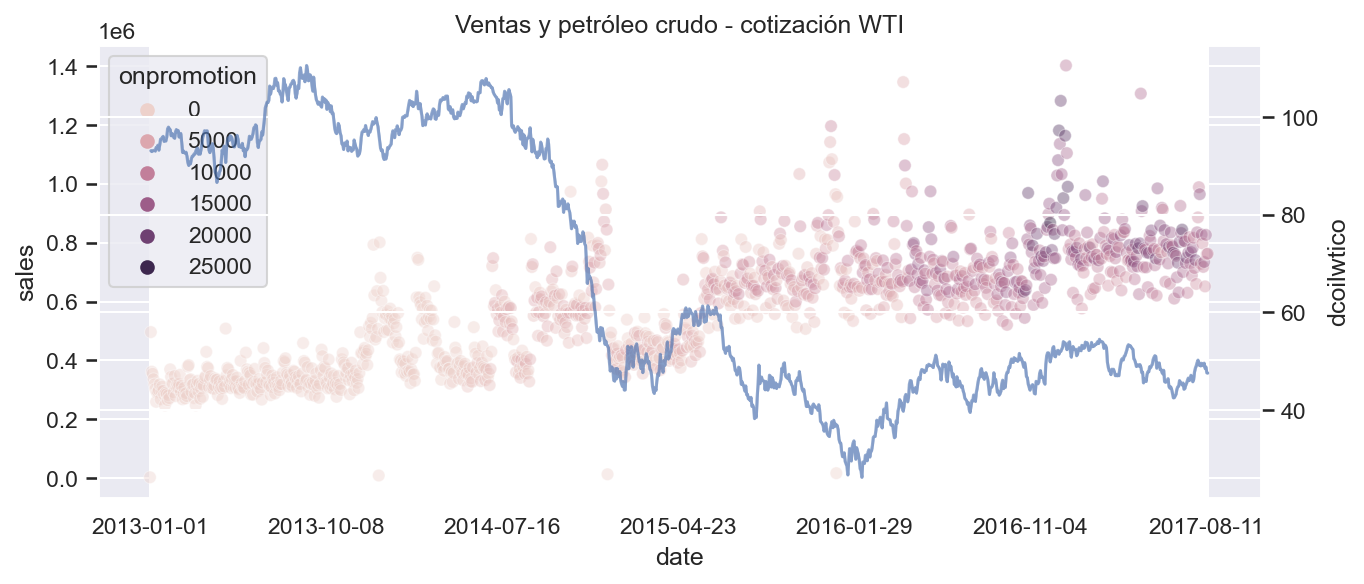

In [43]:
sns.set(rc = {'figure.figsize':(10,4), 'figure.dpi':(150),})
fig1 = sns.scatterplot(data=sales_oil_time,x='date',y='sales',hue='onpromotion',alpha=0.4)
ax2 = plt.twinx()
sns.lineplot(data=sales_per_str,x='date',y='dcoilwtico',ax=ax2,alpha=0.6).set(title='Ventas y petróleo crudo - cotización WTI')
for index, label in enumerate(fig1.get_xticklabels()):
   if index % 200 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)

Puede intuírse una correlación negativa entre *sales* y *dcoilwtico*, y una positiva con *onpromotion*.
Nuestras sospechas se confirman si revisamos la tabla de correlación del desafío pasado.

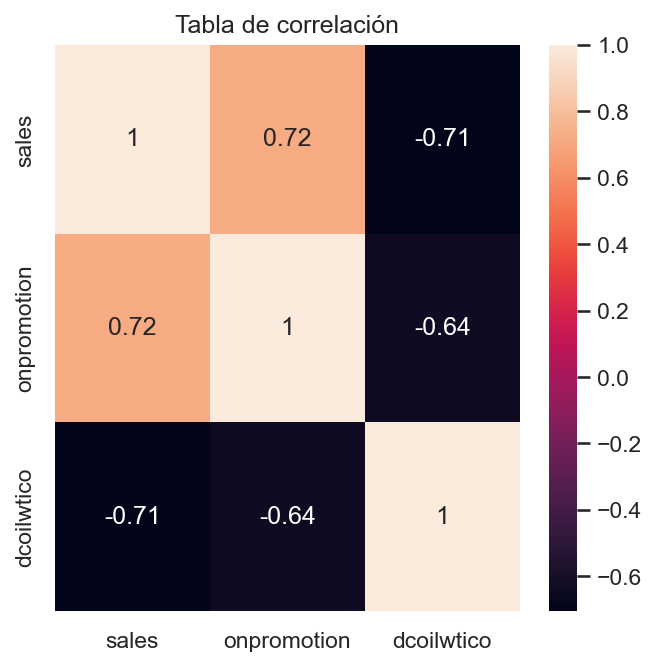

In [74]:
sns.set(rc = {'figure.figsize':(5,5), 'figure.dpi':(150),})

fig2 = sns.heatmap(sales_oil_per_day.corr(),annot=True).set(title='Tabla de correlación')

## ¿Cuánto cambian las ventas por categoría en determinados momentos del año?

Algo que me interesa es ver el comportamiento de cada rubro a lo largo del año. Decidí obtener un promedio de ventas anual y compararlo al promedio de cada día. De esta manera es posible identificar aquellos productos con patrones estacionales, más allá del comportamiento estacional del total de las ventas.

In [66]:
#Promedio de ventas/onpromotion en cada familia, por día del año 

family_mean = train.groupby(by=['date','family'],as_index=False).sum()
family_mean = family_mean.drop(columns=['store_nbr','id'])
family_mean['date'] = pd.to_datetime(family_mean['date'])
family_mean['date'] = family_mean['date'].dt.strftime('%m-%d')
family_mean = family_mean.groupby(by=['date','family'],as_index=False).mean()

family_mean.head()

,date,family,sales,onpromotion
0,01-01,AUTOMOTIVE,2.8,0.0
1,01-01,BABY CARE,0.4,0.0
2,01-01,BEAUTY,4.6,0.0
3,01-01,BEVERAGES,3125.0,8.0
4,01-01,BOOKS,0.0,0.0


In [71]:
#Promedio de ventas/onpromotion diario, sólo agrupado por familia.

family_mean_anual = family_mean.groupby(by='family',as_index=False).mean()
family_mean_anual = family_mean_anual.rename(columns={'sales':'sales_mean','onpromotion':'onpromotion_mean'})

family_mean_anual.head()

,family,sales_mean,onpromotion_mean
0,AUTOMOTIVE,329.362740,2.736986
1,BABY CARE,5.990822,0.032466
2,BEAUTY,201.617260,7.728904
3,BEVERAGES,129618.086849,547.868493
4,BOOKS,4.091918,0.000000


In [76]:
#Unión de las tablas, incluyendo la proporción de cada día del año respecto al "día promedio"

family_mean_prop = family_mean.merge(family_mean_anual,on='family')
family_mean_prop['sales_proportion'] = family_mean_prop['sales']/family_mean_prop['sales_mean']
family_mean_prop['onpromotion_proportion'] = family_mean_prop['onpromotion']/family_mean_prop['onpromotion_mean']

family_mean_prop.head()

,date,family,sales,onpromotion,sales_mean,onpromotion_mean,sales_proportion,onpromotion_proportion
0,01-01,AUTOMOTIVE,2.8,0.0,329.36274,2.736986,0.008501,0.000000
1,01-02,AUTOMOTIVE,459.2,3.2,329.36274,2.736986,1.394207,1.169169
2,01-03,AUTOMOTIVE,395.8,2.0,329.36274,2.736986,1.201715,0.730731
3,01-04,AUTOMOTIVE,359.8,3.4,329.36274,2.736986,1.092413,1.242242
4,01-05,AUTOMOTIVE,348.6,2.6,329.36274,2.736986,1.058408,0.949950


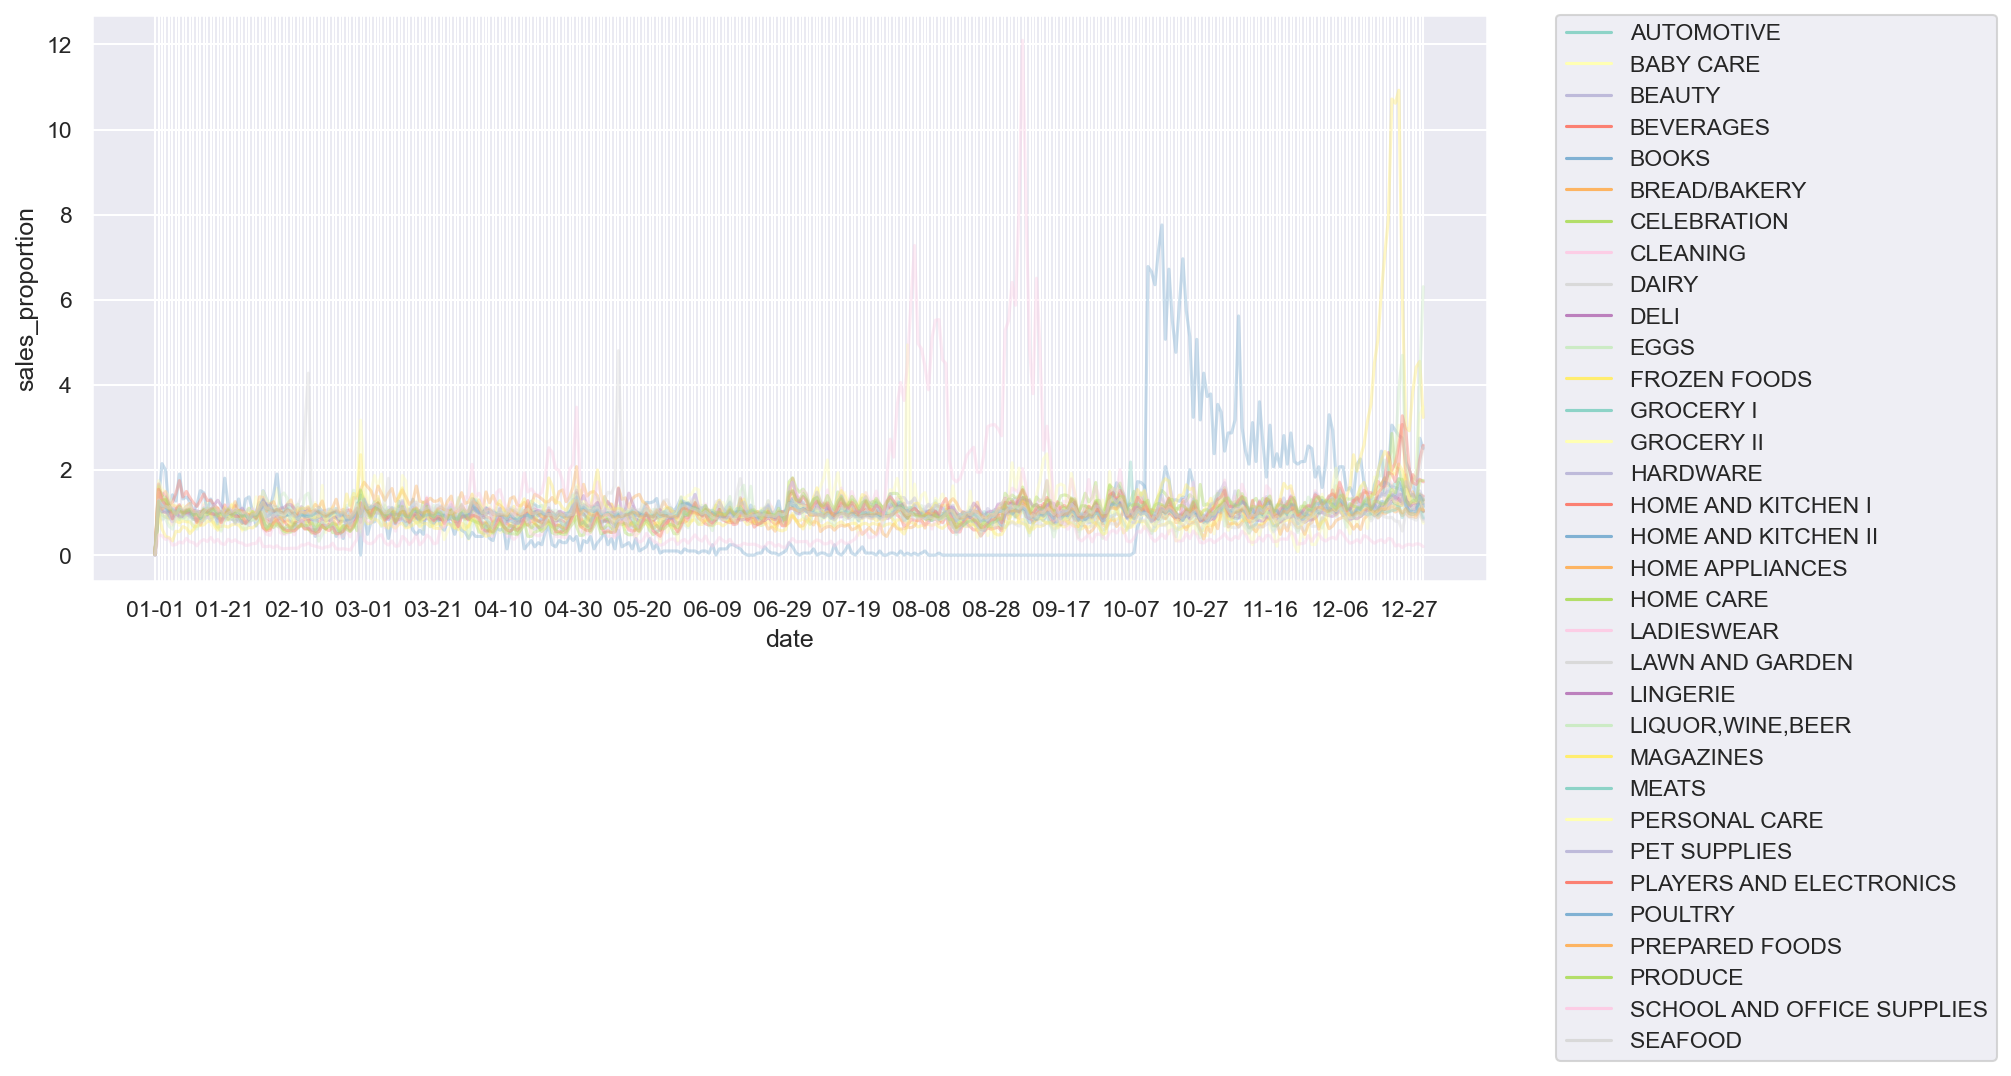

In [117]:
sns.set(rc = {'figure.figsize':(12,5), 'figure.dpi':(150),})

fig3 = sns.lineplot(data=family_mean_prop,x='date',y='sales_proportion',hue='family',alpha=0.4,palette='Set3')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
for index, label in enumerate(fig3.get_xticklabels()):
   if index % 20 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)


Se advierte que ciertas familias tienen un comportamiento estacional muy marcado. Al tener tantas familias, la paleta de colores y la asimetría dificultan mucho identificar cuáles destacan (probé usando escala logarítmica y el resultado no fue satisfactorio).


In [119]:
#Filtro sólo los días y familias con ventas promedio 2 veces o más el promedio diario

family_mean_prop_filt = family_mean_prop
family_mean_prop_filt = family_mean_prop_filt[family_mean_prop_filt['sales_proportion']>2]
family_mean_prop_filt = family_mean_prop_filt.sort_values(by='date')

family_mean_prop_filt.head()

,date,family,sales,onpromotion,sales_mean,onpromotion_mean,sales_proportion,onpromotion_proportion
1462,01-03,BOOKS,8.8,0.0,4.091918,0.000000,2.150581,NaN
1463,01-04,BOOKS,8.2,0.0,4.091918,0.000000,2.003950,NaN
7343,02-13,LAWN AND GARDEN,962.0,0.4,321.055205,6.488356,2.996369,0.061649
7344,02-14,LAWN AND GARDEN,1373.0,7.4,321.055205,6.488356,4.276523,1.140505
8454,02-29,MAGAZINES,377.0,0.0,159.788767,0.183014,2.359365,0.000000


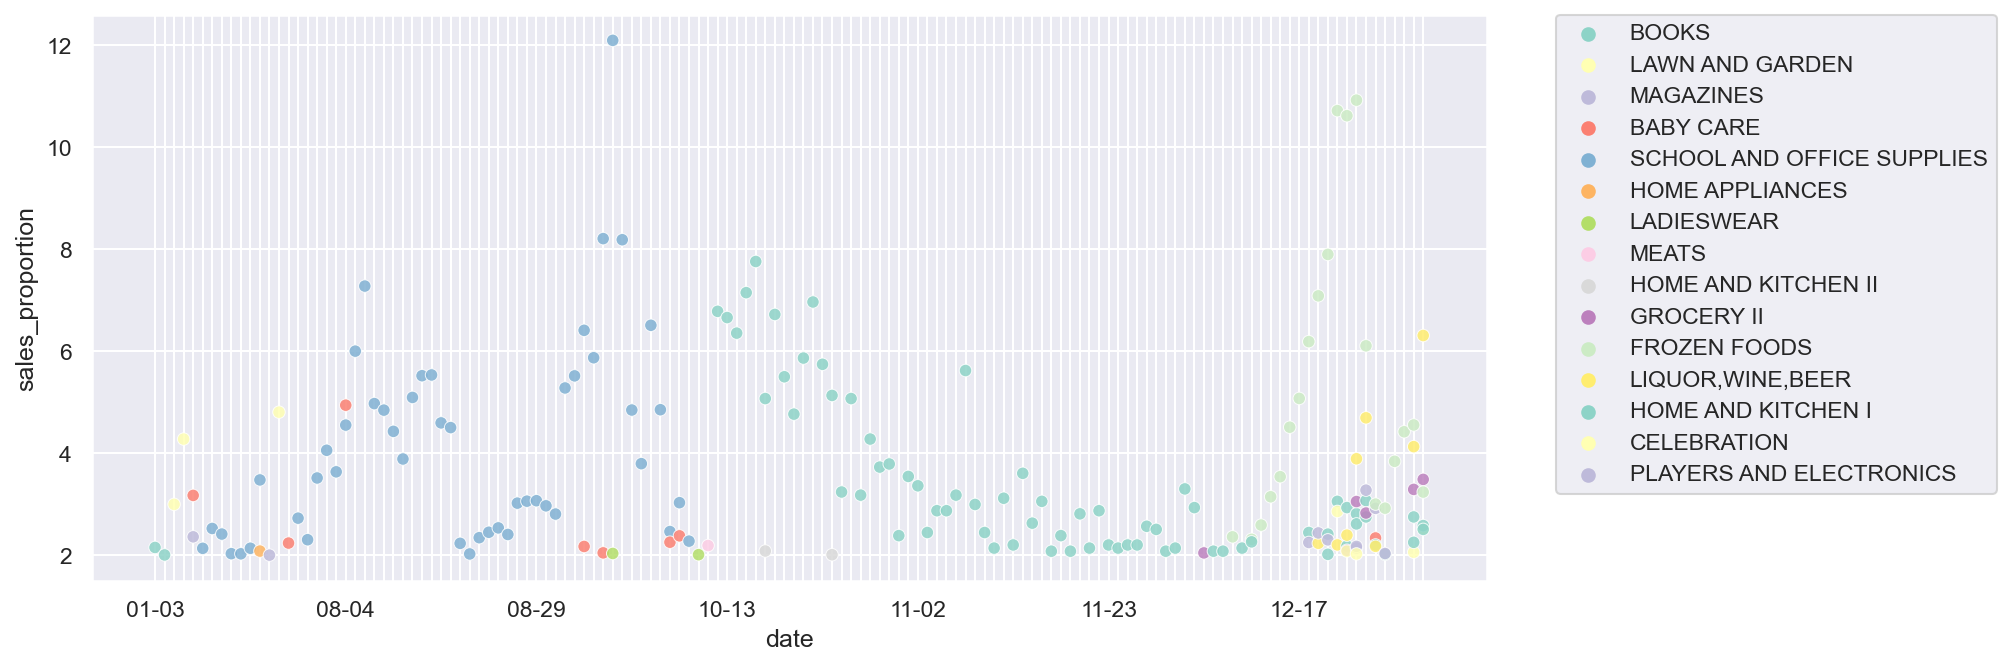

In [120]:
sns.set(rc = {'figure.figsize':(12,5), 'figure.dpi':(150),})

fig4 = sns.scatterplot(data=family_mean_prop_filt,x='date',y='sales_proportion',hue='family',alpha=0.85,palette='Set3')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
for index, label in enumerate(fig4.get_xticklabels()):
   if index % 20 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)


Una forma de aproximar qué categorías tienen esta estacionalidad, aunque rudimentaria, consiste en filtrar el dataframe con los valores donde el proporcional sea mayor a 2.
Pese a que ahora se observan menos familias, se pierden algunas fechas y el gráfico "da saltos" de enero a agosto, por ejemplo.

Intenté lo mismo con la variable *onpromotion* para observar su estacionalidad

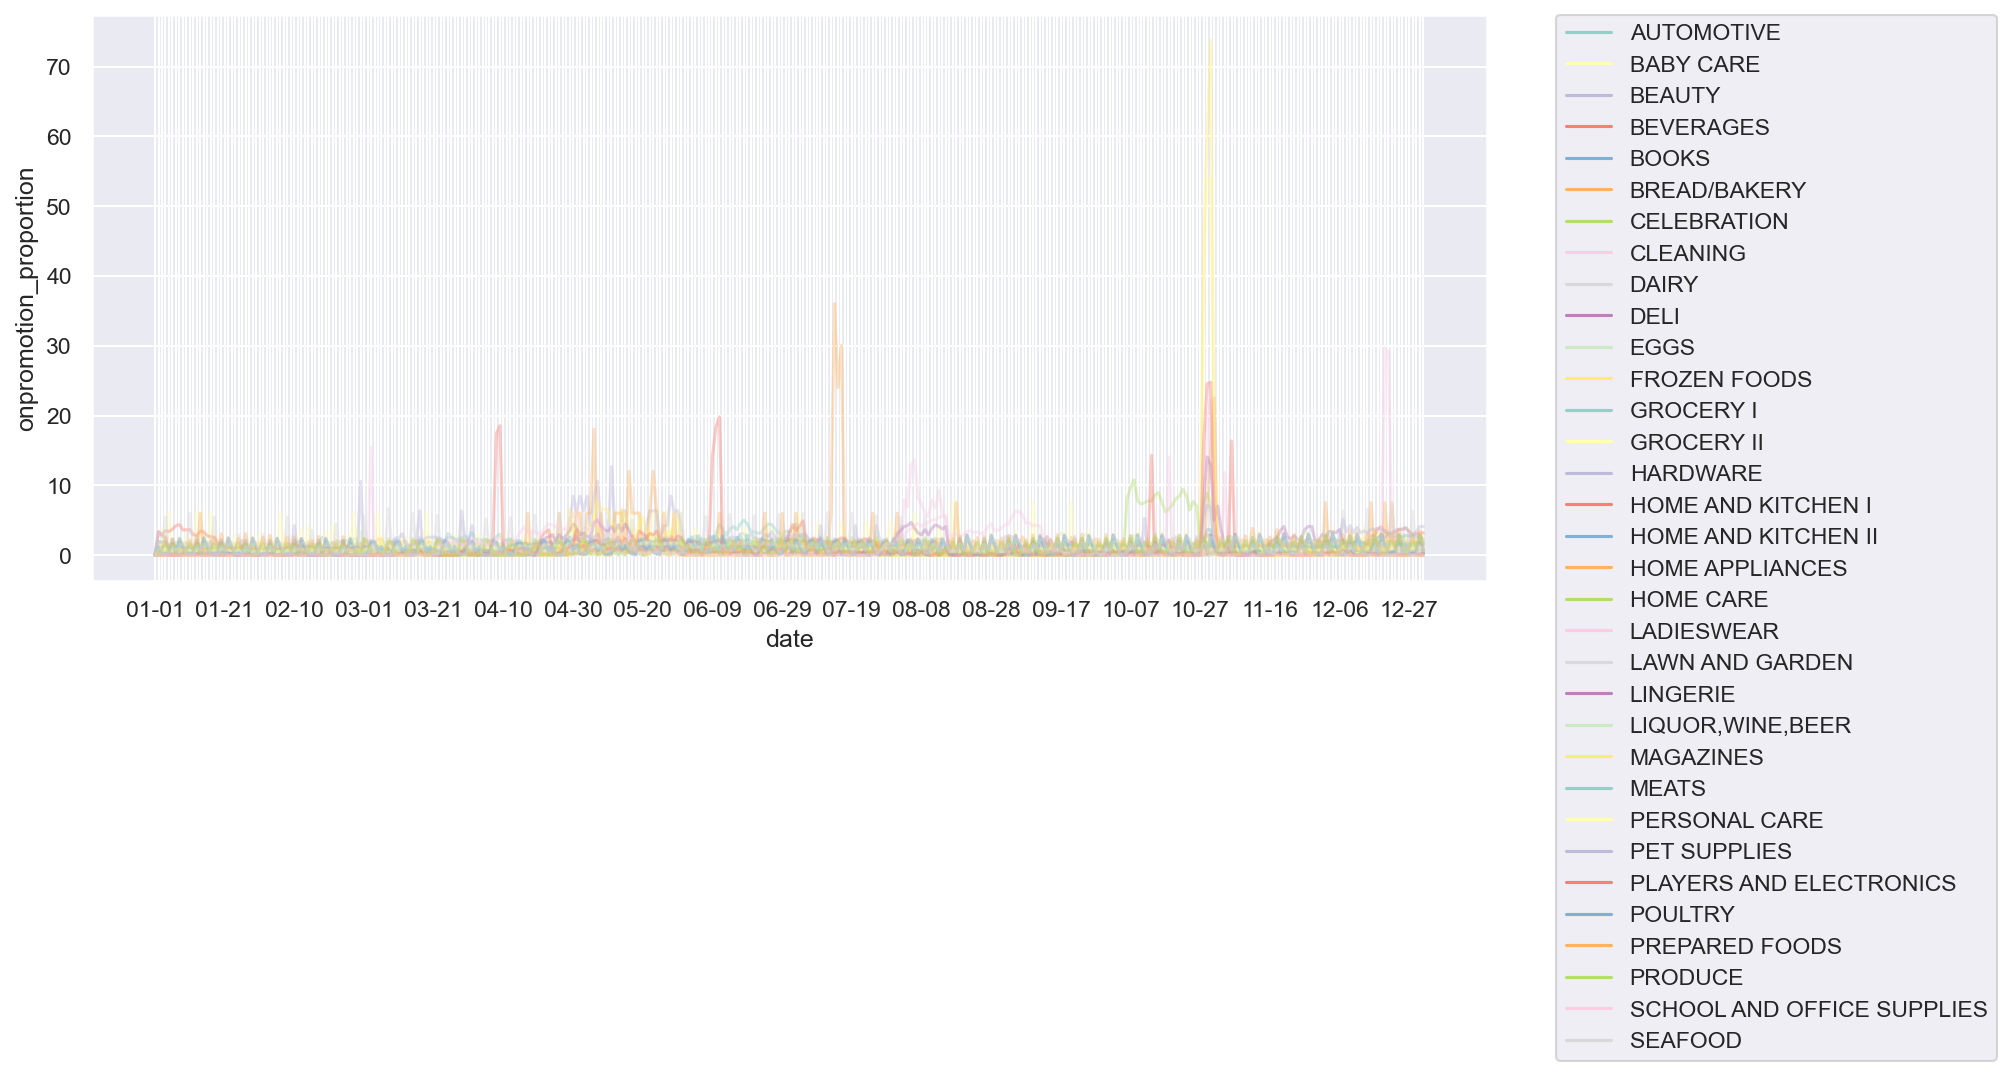

In [126]:
sns.set(rc = {'figure.figsize':(12,5), 'figure.dpi':(150),})

fig5 = sns.lineplot(data=family_mean_prop,x='date',y='onpromotion_proportion',hue='family',alpha=0.4,palette='Set3')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
for index, label in enumerate(fig5.get_xticklabels()):
   if index % 20 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)

Cuando se analizan las promociones, la mayoría de las familias parecen estar menos estacionalizadas. Sería interesante analizar la tabla *holidays* del dataset y evaluar qué categorías tienen más ventas y productos en promoción durante eventos como navidades, días del padre/madre/niño, etc.